# 수요예측 (Client 관점)
#### #온라인 선호지수 이용해서 클러스터 분석해서 수요 트렌드 인사이트 내기

- 온라인 구매선호지수만으로 예측


#### #날짜별로 
- LSTM

#### #데이터 input
[training data]
- week1:2
client1 : 제품 a 를 몇 개 구입
client2: 제품 ㅇ를 몇 개 구입
...
- week3:4
client 1: 
client 2:
..
..
- week5:6
client1:
client2:

[test data]
- week 7:8
client1:
client2:
...

- week 11:12
client1:
client2:


#### #데이터 output
2 weeks별로 각 상품군이 몇개 팔릴 것인가,,,

week 7:8부터

week 11:12 까지 


In [ ]:
import numpy as np
import pandas as pd
import sklearn
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle

In [176]:
product = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/output/product.csv",encoding = "UTF-8", index_col=0)
search1 = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/data/Search1.csv",encoding = "UTF-8")
search2 = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/data/Search2.csv",encoding = "UTF-8")
custom = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/data/Custom.csv",encoding = "UTF-8")
session = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/data/Session.csv",encoding = "UTF-8")
master = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/data/Master.csv",encoding = "UTF-8")

In [31]:
#클러스터링 결과
clustered_10000 = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/output2/clustered_10000.csv", encoding = "UTF-8", index_col=0)
clustered_20000 = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/output2/clustered_20000.csv", encoding = "UTF-8", index_col=0)

In [105]:
#10000명의 clients, 구매선호지수, cosine, kmeans적용
opc1 = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/output2/Online_Preference_Count1.csv", encoding = "UTF-8", index_col=0)
#10000명의 clients, 검색선호지수, cosine, kmeans 적용
ops1 = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/output2/Online_Preference_Search1.csv", encoding = "UTF-8", index_col=0)
#20000명의 clients, 검색선호지수, cosine, kmeans 적용
ops2 = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/output2/Online_Preference_Search2.csv", encoding = "UTF-8", index_col=0)
#opc1과 ops2의 앙상블(교집합 client에 대한)결과
ensemble_op = pd.read_csv("C:/Users/lsh93/Desktop/Lpoint/output2/ensemble_op.csv", encoding = "UTF-8", index_col=0)

In [106]:
#index to column, and rename column name
opc1.reset_index(inplace=True)
opc1 = opc1.rename(columns = {'index':'CLNT_ID'})
ops1.reset_index(inplace=True)
ops1 = ops1.rename(columns = {'index':'CLNT_ID'})
ops2.reset_index(inplace=True)
ops2 = ops2.rename(columns = {'index':'CLNT_ID'})
ensemble_op.reset_index(inplace=True)
ensemble_op = ensemble_op.rename(columns = {'index':'CLNT_ID'})

## 1) 온라인 구매선호지수 이용하여 cluster별로 인사이트 도출하기

- cluster 0,1,2,3 의 특성 도출 : 연령대, 성별
- 각 클러스터 별로 상품군별 구매량 내림차순으로 정리

In [107]:
#구매선호지수 계산에 사용된 4082명의 clients에 대해서만 군집정보 병합
opc1 = pd.merge(opc1, clustered_10000[['CLNT_ID','TOTAL_AMOUNT','CLUSTER']])
len(opc1['CLNT_ID'])

4082

In [57]:
cluster0 = opc1[opc1['CLUSTER'] == 0]
cluster1 = opc1[opc1['CLUSTER'] == 1]
cluster2 = opc1[opc1['CLUSTER'] == 2]
cluster3 = opc1[opc1['CLUSTER'] == 3]
print('cluster0: ',len(cluster0),'명')
print('cluster1: ',len(cluster1),'명')
print('cluster2: ',len(cluster2),'명')
print('cluster3: ',len(cluster3),'명')

cluster0:  904 명
cluster1:  3048 명
cluster2:  7 명
cluster3:  123 명


In [108]:
cluster0 = pd.merge(cluster0, custom)
cluster1 = pd.merge(cluster1, custom)
cluster2 = pd.merge(cluster2, custom)
cluster3 = pd.merge(cluster3, custom)
print('cluster0: ',len(cluster0),'명')
print('cluster1: ',len(cluster1),'명')
print('cluster2: ',len(cluster2),'명')
print('cluster3: ',len(cluster3),'명')

cluster0:  904 명
cluster1:  3048 명
cluster2:  7 명
cluster3:  123 명


In [109]:
cluster0.head()

,CLNT_ID,스포츠패션,남성의류,유아동의류,청소/세탁/욕실용품,완구,패션잡화,시즌스포츠,여성의류,인테리어/조명,...,냉장식품,원예/애완,상품권,자동차용품,축산물,영상/음향가전,TOTAL_AMOUNT,CLUSTER,CLNT_GENDER,CLNT_AGE
0,3281841,10.677918,2.788626,2.905331,0.703344,0.234448,3.951522,0.252839,2.487330,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,45,0,F,30
1,3431781,2.003078,8.482604,6.495382,0.000000,0.000000,0.244496,0.244496,0.511007,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,33,0,F,40
2,6195657,1.034911,0.995647,23.068621,0.000000,0.000000,2.908747,1.489075,2.789606,0.696734,...,0.0,0.0,0.000000,0.0,0.0,0.0,66,0,F,40
3,5703539,3.723149,1.538078,15.218197,0.756274,0.000000,4.522500,0.996683,4.084759,0.000000,...,0.0,0.0,0.255409,0.0,0.0,0.0,73,0,F,30
4,321800,7.863357,5.596101,20.707539,0.000000,0.256729,4.542579,2.694427,5.881681,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,77,0,F,40


*cluster 0 : 

1. 연령분포:
 40    422
30    379
20     50
50     45
60      5
80      1
70      1
10      1
Name: CLNT_AGE, dtype: int64

2. 나이분포:
 F    836
M     68
Name: CLNT_GENDER, dtype: int64

3. 제품군분포:
 여성의류        7627.75
화장품/뷰티케어    5838.13
유아동의류          4241
스포츠패션       4137.89
dtype: object


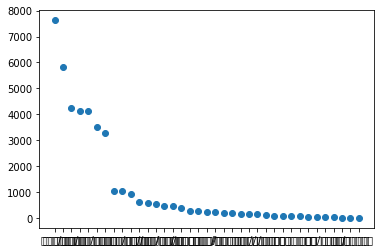

In [163]:
print('*cluster 0 : \n')
print('1. 연령분포:\n',cluster0['CLNT_AGE'].value_counts())
print()
print('2. 나이분포:\n',cluster0['CLNT_GENDER'].value_counts())
print()
sum0 = cluster0.sum()
sum0 = sum0[1:38]
sum0 = sum0.sort_values(ascending = False)
print('3. 제품군분포:\n',sum0[0:4])
plt.scatter(sum0.index.values, sum0.values)

*cluster 1 : 

1. 연령분포:
 30    1472
40    1078
20     341
50     108
10      36
60      13
Name: CLNT_AGE, dtype: int64

2. 나이분포:
 F    2761
M     287
Name: CLNT_GENDER, dtype: int64

3. 제품군분포:
 화장품/뷰티케어    6448.29
스포츠패션       4998.45
유아동의류       4896.07
여성의류        4710.75
dtype: object


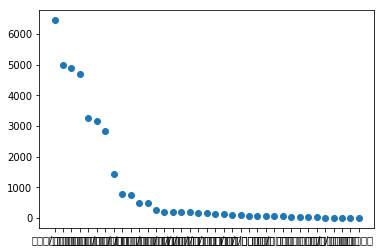

In [162]:
print('*cluster 1 : \n')
print('1. 연령분포:\n',cluster1['CLNT_AGE'].value_counts())
print()
print('2. 나이분포:\n',cluster1['CLNT_GENDER'].value_counts())
print()
sum1 = cluster1.sum()
sum1 = sum1[1:38]
sum1 = sum1.sort_values(ascending = False)
print('3. 제품군분포:\n',sum1[0:4])
plt.scatter(sum1.index.values, sum1.values)

*cluster 2 : 

1. 연령분포:
 40    4
30    3
Name: CLNT_AGE, dtype: int64

2. 나이분포:
 F    7
Name: CLNT_GENDER, dtype: int64

3. 제품군분포:
 여성의류        495.972
스포츠패션       167.035
화장품/뷰티케어    147.129
남성의류         117.16
dtype: object
4. 총 구매량:
 1336.8377717160656


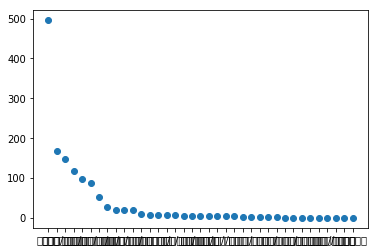

In [168]:
print('*cluster 2 : \n')
print('1. 연령분포:\n',cluster2['CLNT_AGE'].value_counts())
print()
print('2. 나이분포:\n',cluster2['CLNT_GENDER'].value_counts())
print()
sum2 = cluster2.sum()
sum2 = sum2[1:38]
sum2 = sum2.sort_values(ascending = False)
print('3. 제품군분포:\n',sum2[0:4])
print('4. 총 구매량:\n',sum2.sum())
plt.scatter(sum2.index.values, sum2.values)

*cluster 3 : 

1. 연령분포:
 40    64
30    44
50    11
20     2
70     1
60     1
Name: CLNT_AGE, dtype: int64

2. 나이분포:
 F    112
M     11
Name: CLNT_GENDER, dtype: int64

3. 제품군분포:
 여성의류        3076.93
화장품/뷰티케어    1421.52
스포츠패션       1042.69
남성의류        1004.02
dtype: object


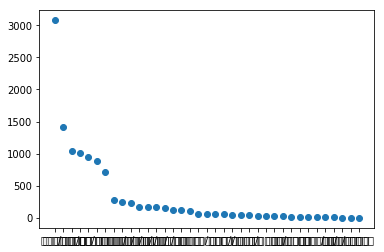

In [160]:
print('*cluster 3 : \n')
print('1. 연령분포:\n',cluster3['CLNT_AGE'].value_counts())
print()
print('2. 나이분포:\n',cluster3['CLNT_GENDER'].value_counts())
print()
sum3 = cluster3.sum()
sum3 = sum3[1:38]
sum3 = sum3.sort_values(ascending = False)
print('3. 제품군분포:\n',sum3[0:4])
plt.scatter(sum3.index.values, sum3.values)

## 2)날짜별로, 제품군 수요 예측하기

- 데이터 정리

In [175]:
#10000명 샘플링 한 결과를 이용해 보자 
clients = clustered_10000
product.head()

,Unnamed: 0,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,1,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK|사이즈:120 / 2개,데상트,"39,000",2
1,132425,4140076,10342512,23,422358,선택:02.204143-02S|사이즈:M5W7(240) / 1개,크록스,"39,900",1
2,647279,4140076,6526651,22,196272,색상:선택3)248(네이비)|사이즈:L(105) / 1개,프레드페리,"47,600",1
3,673008,4140076,8326529,199,305965,사이즈:115_3XL / 1개,아디다스(의류),"46,700",1
4,720869,4140076,8891563,19,305965,사이즈:115_3XL / 1개,아디다스(의류),"46,700",1


In [172]:
product = pd.merge(product, clients[['CLNT_ID']])
len(product['CLNT_ID'].unique())

10001

In [173]:
product.head()

,Unnamed: 0,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,1,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK|사이즈:120 / 2개,데상트,"39,000",2
1,132425,4140076,10342512,23,422358,선택:02.204143-02S|사이즈:M5W7(240) / 1개,크록스,"39,900",1
2,647279,4140076,6526651,22,196272,색상:선택3)248(네이비)|사이즈:L(105) / 1개,프레드페리,"47,600",1
3,673008,4140076,8326529,199,305965,사이즈:115_3XL / 1개,아디다스(의류),"46,700",1
4,720869,4140076,8891563,19,305965,사이즈:115_3XL / 1개,아디다스(의류),"46,700",1
